<a href="https://colab.research.google.com/github/mehrn79/NMT/blob/src/NMT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Embedding, Dropout, Concatenate, Activation, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import numpy as np
import string
import json
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import CuDNNLSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/MyDrive/language_data.csv' language_data.csv

Mounted at /content/drive


In [3]:
with open('/content/language_data.csv') as f:
  language_data = f.read()

In [4]:
language_data = pd.read_csv('language_data.csv')
english_text = language_data['English'].values
persian_text = language_data['Persian'].values
english_text[0].replace('\ufeff','')

'raspy breathing .'

In [5]:
# Lowercase and remove punctuation in sentences
def clean_sentence(sentence):
    # Add a space ' ' befor the ? word
    sentence = sentence.replace('?', ' ?')
    # Lower case the sentence
    lower_case_sent = sentence.lower()
    # Strip punctuation
    string_punctuation = string.punctuation  # !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    string_punctuation = string_punctuation.replace('?','')
    # Clean the sentence
    clean_sentence = lower_case_sent.translate(str.maketrans('', '', string_punctuation))
    return clean_sentence

In [6]:
english_sent = [clean_sentence(pair) for pair in english_text]
persian_sent = [clean_sentence(pair) for pair in persian_text]

In [7]:
X_train_decoder   = []
Y_train_decoder   = []
persian_sentences = []

# Add <start> token at start of every input decoder sentence and
# add <end> token at end of every target decoder sentence.
for sentence in persian_sent:
    X_train_decoder.append("<start> " + sentence)
    Y_train_decoder.append(sentence + " <end>")
    persian_sentences.append("<start> " + sentence + " <end>")

In [8]:
def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer(filters='')
    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [9]:
# Tokenize encoder input
en_text_tokenized, en_text_tokenizer = tokenize(english_sent)
# Tokenize decoder input
_, per_text_tokenizer = tokenize(persian_sentences)
per_in_text_tokenized = per_text_tokenizer.texts_to_sequences(X_train_decoder)
per_out_text_tokenized = per_text_tokenizer.texts_to_sequences(Y_train_decoder)

In [10]:
# Let's add 0 padding to the sentences, to make sure they are all the same length.
# That is, we must be sure that all Italian sentences have the same length as the
# longest Italian sentence and that all English sentences have the same length
# as the longest English sentence
X_train_encoder = pad_sequences(en_text_tokenized, padding="post")
X_train_decoder = pad_sequences(per_in_text_tokenized, padding="post")
Y_train_decoder = pad_sequences(per_out_text_tokenized, padding="post")

# Let's check the length of the vocabulary
# Let's add one unit to size for 0 padding
english_vocab_size = len(en_text_tokenizer.word_index) + 1
persian_vocab_size = len(per_text_tokenizer.word_index) + 1

# get the lenght of max italian/english sentence
max_english_len = X_train_encoder[0].shape[0]
max_persian_len = X_train_decoder[0].shape[0]

In [ ]:
len(X_train_encoder)

612086

In [11]:
X_train_encoder_ = X_train_encoder[:400000]
X_train_decoder_ = X_train_decoder[:400000]
Y_train_decoder_ = Y_train_decoder[:400000]

X_valid_encoder = X_train_encoder[400001:500000]
X_valid_decoder = X_train_decoder[400001:500000]
Y_valid_decoder = Y_train_decoder[400001:500000]

X_test_encoder = X_train_encoder[500001:]
X_test_decoder = X_train_decoder[500001:]
Y_test_decoder = Y_train_decoder[500001:]

X_train_encoder = X_train_encoder_
X_train_decoder = X_train_decoder_
Y_train_decoder = Y_train_decoder_

print("Train set has %d sentences" %len(X_train_encoder))
print("Validation set has %d sentences" %len(X_valid_encoder))
print("Test set has %d sentences" %len(X_test_encoder))

Train set has 400000 sentences
Validation set has 99999 sentences
Test set has 112085 sentences


In [12]:
# Encoder
encoder_input = Input(shape=[None], dtype=tensorflow.int32)
encoder_embedding = Embedding(input_dim=english_vocab_size+1,
                              output_dim=256,
                              )(encoder_input)

_, enc_state_h, enc_state_c = tensorflow.compat.v1.keras.layers.CuDNNLSTM(256, #dropout=0.3,
                                        #recurrent_dropout=0.3,
                                      return_state=True,
                                      return_sequences=False)(encoder_embedding)
# Save the state of the last step of the encoder which will be the initial state of the decoder.
encoder_state = [enc_state_h, enc_state_c]  

# Decoder
decoder_input = Input(shape=[None], dtype=tensorflow.int32)
decoder_embedding = Embedding(input_dim=persian_vocab_size+1,
                              output_dim=256,
                              )(decoder_input)
decoder_lstm_output, dec_state_h, dec_state_c = tensorflow.compat.v1.keras.layers.CuDNNLSTM(256, #dropout=0.3,
                                                          #recurrent_dropout=0.3,
                                                    return_sequences=True,
                                                    return_state=True)(decoder_embedding, initial_state=encoder_state)
        
decoder_lstm_output_dropout = Dropout(0.5)(decoder_lstm_output)
decoder_output = TimeDistributed(Dense(persian_vocab_size, activation="softmax"))(decoder_lstm_output_dropout)

# Define model
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    19988992    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    35265024    ['input_2[0][0]']                
                                                                                              

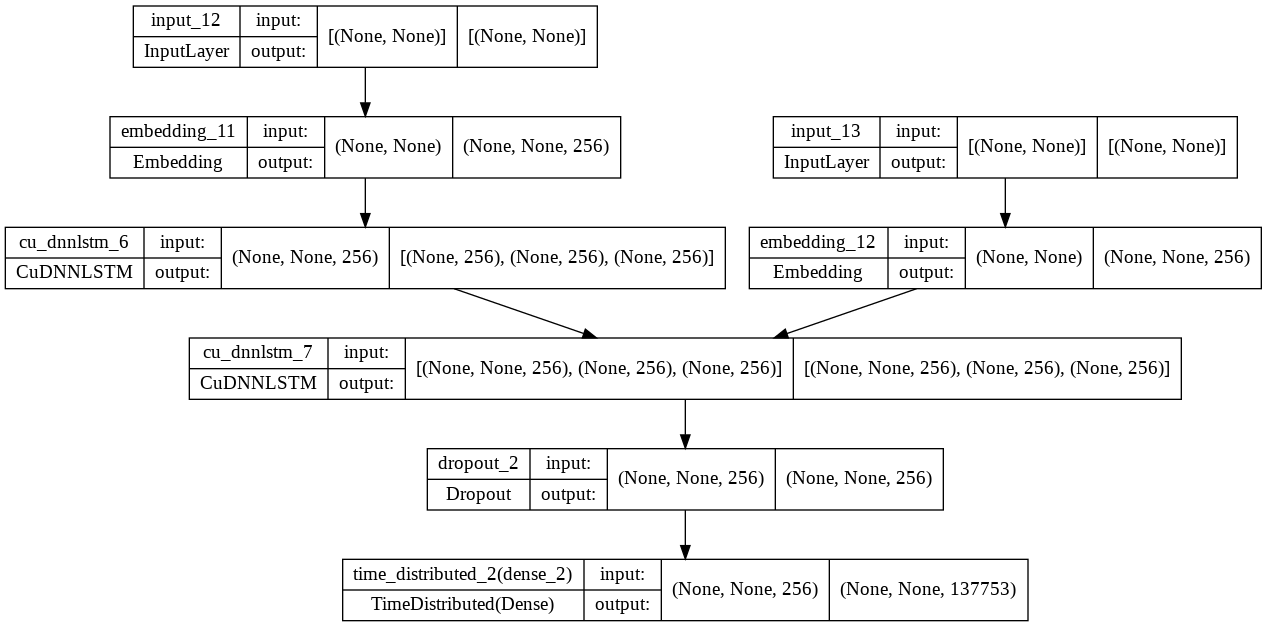

In [ ]:
tensorflow.keras.utils.plot_model(model, to_file='model_without_attention.png', show_shapes=True)

In [18]:
model_name = "without_attention.h5"
mcp_save = ModelCheckpoint(filepath=model_name,
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min',
                           verbose=1)

history = model.fit([X_train_encoder, X_train_decoder], Y_train_decoder,
                    epochs=25,
                    validation_data=([X_valid_encoder, X_valid_decoder], Y_valid_decoder),
                    verbose=2,
                    batch_size=32,
                    callbacks=mcp_save)

model.save("final_epoch_"+model_name)

history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('history.json', 'w'))

Epoch 1/25

Epoch 1: val_loss improved from inf to 1.28916, saving model to without_attention.h5
12500/12500 - 4931s - loss: 1.3051 - accuracy: 0.8223 - val_loss: 1.2892 - val_accuracy: 0.8306 - 4931s/epoch - 394ms/step
Epoch 2/25


KeyboardInterrupt: ignored